In [1]:
# MACD trading signal.
# https://tcoil.info/compute-macd-indicator-for-stocks-with-python/
# http://www.andrewshamlet.net/2017/08/10/python-tutorial-macd-signal-line-centerline-crossovers/

# https://tradewithpython.com/generating-buy-sell-signals-using-python
# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#trend-indicators
# https://stackoverflow.com/questions/62969946/how-to-find-macd-and-signal-for-multiple-stocks-in-python-using-yfinance-and-pan

In [2]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd
from scipy import stats

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import os.path
import webbrowser

#newest yahoo API 
import yfinance as yahoo_finance

# add subplot.
import matplotlib.gridspec as gridspec

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# # ___variables___
# #ticker = 'AAPL'

# start_time = datetime.datetime(2018, 1, 1)
# #end_time = datetime.datetime(2019, 1, 20)
# end_time = datetime.datetime.now().date().isoformat()         # today

In [4]:
# # yahoo gives only daily historical data
# connected = False
# while not connected:
#     try:
#         ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
#         connected = True
#         print('connected to yahoo')
#     except Exception as e:
#         print("type error: " + str(e))
#         time.sleep( 5 )
#         pass   

# # use numerical integer index instead of date    
# ticker_df = ticker_df.reset_index()
# print(ticker_df.head(5))

In [5]:
# Compute MACD metrics.
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [6]:
#signalling algorithm modified from
#https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience

# def generate_signals_MACD(df):
#     buy_list = []
#     sell_list = []
#     flag = -1

#     for i in range(0,len(df)):
#         if df['MACD'][i] > df['MACDsig'][i] :         # first occurence of MACD crossing above signal oine
#             sell_list.append(np.nan)                 # so first flip above means buy
#             if flag != 1:                            # after first occurence I record flip to ignore
#                 buy_list.append(df['Close'][i])      # from here onwards
#                 flag = 1
#             else:
#                 buy_list.append(np.nan)
#         elif df['MACD'][i] < df['MACDsig'][i]:
#             buy_list.append(np.nan)
#             if flag != 0:
#                 sell_list.append(df['Close'][i])
#                 flag = 0
#             else:
#                 sell_list.append(np.nan)
#         else:
#             buy_list.append(np.nan)
#             sell_list.append(np.nan)
            
#     return (buy_list, sell_list)            




In [7]:
# Generate EMA short and long cross-over signals.
def generate_signals_EMA(df):
    buy_list = []
    sell_list = []
    flag = -1

    for i in range(0,len(df)):
        if df['EMA_short'][i] > df['EMA_long'][i] :         # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                 # so first flip above means buy
            if flag != 1:                            # after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onwards
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['EMA_short'][i] < df['EMA_long'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            

In [8]:
# Generate close and EMA_short cross-over signals.
# if close price above EMA_short 3 days continously, assign close price to buy_sig_EMA
# if close price below EMA_short 3 days continously, assign close price to sell_sig_EMA
def generate_signals_EMA2(df):
    buy_list = []
    sell_list = []
    flag = -1
    buy_counter = 0
    sell_counter = 0
    
    bc_days = 7       # continous 6 trading days.
    sc_days = 3       # continous 2 trading days.
    for i in range(0,len(df)):
        if df['Close'][i] > df['EMA_short'][i] :    
            sell_list.append(np.nan)                    
            buy_counter += 1
            sell_counter = 0
            if ((flag != 1)  & (buy_counter >= bc_days)):  # first continuous occurences of Close crossing above EMA_short, after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onwards
                flag = 1
                buy_counter = 0
            else:
                buy_list.append(np.nan)
        elif df['Close'][i] < df['EMA_short'][i]  :
            buy_counter =0
            sell_counter += 1
            
            buy_list.append(np.nan)
            if ((flag != 0) & (sell_counter >= sc_days)):
                sell_list.append(df['Close'][i])
                flag = 0
                sell_counter = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            

In [9]:
# def plot_signals(df, ticker):
#     # plot price
#     plt.figure(figsize=(15,5))
#     plt.plot(df.index, df['Close'])
#     plt.title('Price chart (Close) ' + str(ticker))
#     plt.show()

#     # plot  values and significant levels
#     plt.figure(figsize=(15,5))
#     plt.title('Bollinger Bands chart ' + str(ticker))
#     plt.plot(df.index, df['High'], label='High', alpha=0.2)
#     plt.plot(df.index, df['Low'], label='Low', alpha=0.2)
#     plt.plot(df.index, df['Close'], label='Close', color='blue', alpha=0.3)

#     plt.scatter(df.index, df['buy_sig'], label='Buy', marker='^')
#     plt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

#     plt.legend()

#     plt.show()
       
#     plt.figure(figsize=(15,5))
#     plt.title('MACD chart ' + str(ticker))
#     plt.plot(df.index, df['MACD'].fillna(0))
#     plt.plot(df.index, df['MACDsig'].fillna(0))
#     plt.plot(df.index, df['MACDhist'].fillna(0))
#     plt.bar(df.index, df['MACDhist'].fillna(0), width=0.5, snap=False)
    
#     return None

In [10]:
#plot_signals(df, ticker)

In [11]:
# Modified buy/sell signalling - long only below zero line, short only above zero line

In [12]:
# Calculate close price EMA.
def get_EMA(df, nshort=20, nlong=50,nx=100):
    # computes EMA
    ema_short = df['Close'].ewm(span=nshort, adjust=False).mean()
    ema_long = df['Close'].ewm(span=nlong, adjust=False).mean()
    ema_x = df['Close'].ewm(span=nx, adjust=False).mean()
    
    ema = df['Close'].ewm(span=7, adjust=False).mean()
    
    df['EMA'] = ema
    df['EMA_short'] = ema_short
    df['EMA_long'] = ema_long
    df['EMA_x'] = ema_x
    
    return df

In [13]:
# Calculate close price SMA.
def get_SMA(df, nshort=20, nlong=50,nx=100):
    # computes EMA
    ema_short = df['Close'].rolling(window = nshort, min_periods = 1).mean()
    ema_long = df['Close'].rolling(window = nshort, min_periods = 1).mean()
    ema_x = df['Close'].rolling(window = nshort, min_periods = 1).mean()
    
    ema = df['Close'].ewm(span=7, adjust=False).mean()
    
    df['EMA'] = ema
    df['EMA_short'] = ema_short
    df['EMA_long'] = ema_long
    df['EMA_x'] = ema_x
    
    return df

In [14]:
# Calculate SMA for volume.
def get_SMA_volume(df, nshort=5, nlong=20):
    # computes EMA
    ema_short = df['Volume'].rolling(window = nshort, min_periods = 1).mean()
    ema_long = df['Volume'].rolling(window = nlong, min_periods = 1).mean()
    
    df['Volume_MA_short'] = ema_short
    df['Volume_MA_long'] = ema_long

    return df

In [15]:
# Generate buy/sell list for MACD signals.
#modified strategy according to tradingrush
#https://www.youtube.com/watch?v=nmffSjdZbWQ&ab_channel=TRADINGRUSH
#Not sure if using EMA is that beneficial, if so, use like 5-7 days only for short term trend

def generate_signals_MACD(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        # BUY
        if (df['MACD'][i] > df['MACDsig'][i]):      # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                # so first flip above means buy
            if (flag != 1) :                        # after first occurence i record flip to ignore
                                                    # from here onwards
                flag = 1
                
                # looking for higher magnitudes 
                if (   (df['High'][i] > df['EMA'][i])   and   (df['MACD'][i] < 0)   ):
                    buy_list.append(df['Close'][i])
                else:
                    buy_list.append(np.nan) 
            else:
                buy_list.append(np.nan)
        
        # SELL
        elif (df['MACD'][i] < df['MACDsig'][i]):
            buy_list.append(np.nan)
            if (flag != 0) :
                flag = 0
                
                # looking for higher magnitudes
                if ( (df['Low'][i] < df['EMA'][i])   and  (df['MACD'][i] > 0)   ) :
                    sell_list.append(df['Close'][i])  
                else:
                    sell_list.append(np.nan)    
                
            else:
                sell_list.append(np.nan)
        
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            




In [16]:
# Plot charts.
def plot_signals_aligned(df, ticker, png_file):
    
    #import matplotlib.gridspec as gridspec
    gs =  gridspec.GridSpec(4,1)
    fig = plt.figure(figsize=(12,16))   
    png_file = png_file
       
    plt.style.use('ggplot')
    #sns.set_theme(style="darkgrid")
    #sns.set_theme()
    
    # __first plot__ ???
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df.index, df['Close'], label='Close',color='black', alpha=0.5)
    #sns.lineplot(x=df.index, y=df['Close'], label='Close')
    ax1.set_title('Price chart (Close) ' + str(ticker))
    ax1.legend(loc = 'upper left')

    
    # __second plot__
    # plot  values and significant levels
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
#     ax2.set_title('Bollinger Bands chart ' + str(ticker))
#     ax2.plot(df.index, df['High'], label='High', alpha=0.2)
#     ax2.plot(df.index, df['Low'], label='Low', alpha=0.2)
#     ax2.plot(df.index, df['Adj Close'], label='Adj Close', color='black', alpha=0.3)

    ax2.set_title('Moving Average chart ' + str(ticker), fontsize = 12)
    ax2.plot(df.index, df['Close'], label='Close', color='black', alpha=0.5)
    #sns.lineplot(x=df.index, y=df['Close'], label='Close', color='black', alpha=0.5)
    ax2.plot(df.index, df['EMA_short'], label=str(EMA_short), color='b', alpha=0.7)
    ax2.plot(df.index, df['EMA_long'], label=str(EMA_long), color='g', alpha=0.7)
    ax2.plot(df.index, df['EMA_x'], label=str(EMA_x), color='r', alpha=0.7)
    
    ax2.scatter(df.index, df['buy_sig_adj'], label='Buy', marker='^', s=80,color='b')
    ax2.scatter(df.index, df['sell_sig_adj'], label='Sell', marker='v', s=80, color='r')
    
    ax2.scatter(df.index, df['buy_sig_EMA'], label='Buy', marker='^', s=40,color='b')
    ax2.scatter(df.index, df['sell_sig_EMA'], label='Sell', marker='v', s=40, color='r')

    ax2.legend(loc = 'upper left')

    # __third plot__
    ax3 = fig.add_subplot(gs[2], sharex=ax2)

    ax3.set_title('MACD chart ' + str(ticker), fontsize = 12)
    ax3.plot(df.index, df['MACD'].fillna(0), label='MACD', color='b')
    ax3.plot(df.index, df['MACDsig'].fillna(0), label='MACDsig', color='r')
    #ax3.plot(df.index, df['MACDhist'].fillna(0), label='MACDhist')
    ax3.bar(df.index, df['MACDhist'].fillna(0), width=0.5, snap=False, label='MACDhist', color = 'steelblue')
    ax3.legend(loc = 'upper left')

    #  __fourth plot__
    ax4 = fig.add_subplot(gs[3], sharex=ax3)

    ax4.set_title('Volumn chart ' + str(ticker), fontsize = 12)
    ax4.bar(df.index, df['Volume'].fillna(0), label='Volume', color='black', alpha=0.7)
    ax4.plot(df.index, df['Volume_MA_short'].fillna(0), label=str(Volume_short), color='b', alpha=0.7)
    ax4.plot(df.index, df['Volume_MA_long'].fillna(0), label=str(Volume_long), color='r', alpha=0.7)
    ax4.legend(loc = 'upper left')
    
    #ax4.set_xticklabels(df.index, rotation=90, ha='right')
    
    plt.show()
    
    if os.path.isfile(png_file):
       os.remove(png_file)

    fig.savefig(png_file)
    plt.close()
    #print('Saved figure to file: ', png_file)
    return None

In [17]:
# Plot charts.
def plot_signals_aligned_hourly(df, ticker, png_file):
    
    #import matplotlib.gridspec as gridspec
    gs =  gridspec.GridSpec(4,1)
    fig = plt.figure(figsize=(12,16))   
    png_file = png_file
       
    plt.style.use('ggplot')
    #sns.set_theme(style="darkgrid")
    #sns.set_theme()
    
    # __first plot__ ???
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df.index.strftime('%Y-%m-%d %H:%M'),  df['Close'], label='Close',color='black', alpha=0.5)
    #sns.lineplot(x=df.index, y=df['Close'], label='Close')
    ax1.set_title('Price chart (Close) ' + str(ticker))
    ax1.legend(loc = 'upper left')

    
    # __second plot__
    # plot  values and significant levels
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
#     ax2.set_title('Bollinger Bands chart ' + str(ticker))
#     ax2.plot(df.index, df['High'], label='High', alpha=0.2)
#     ax2.plot(df.index, df['Low'], label='Low', alpha=0.2)
#     ax2.plot(df.index, df['Adj Close'], label='Adj Close', color='black', alpha=0.3)

    ax2.set_title('Moving Average chart ' + str(ticker), fontsize = 12)
    ax2.plot(df.index.strftime('%Y-%m-%d %H:%M'),  df['Close'], label='Close', color='black', alpha=0.5)
    #sns.lineplot(x=df.index, y=df['Close'], label='Close', color='black', alpha=0.5)
    ax2.plot(df.index.strftime('%Y-%m-%d %H:%M'),  df['EMA_short'], label=str(EMA_short), color='b', alpha=0.7)
    ax2.plot(df.index.strftime('%Y-%m-%d %H:%M'),  df['EMA_long'], label=str(EMA_long), color='g', alpha=0.7)
    ax2.plot(df.index.strftime('%Y-%m-%d %H:%M'),  df['EMA_x'], label=str(EMA_x), color='r', alpha=0.7)
    
    ax2.scatter(df.index.strftime('%Y-%m-%d %H:%M'),  df['buy_sig_adj'], label='Buy', marker='^', s=80,color='b')
    ax2.scatter(df.index.strftime('%Y-%m-%d %H:%M'),  df['sell_sig_adj'], label='Sell', marker='v', s=80, color='r')
    
    ax2.scatter(df.index.strftime('%Y-%m-%d %H:%M'),  df['buy_sig_EMA'], label='Buy', marker='^', s=40,color='b')
    ax2.scatter(df.index.strftime('%Y-%m-%d %H:%M'),  df['sell_sig_EMA'], label='Sell', marker='v', s=40, color='r')

    ax2.legend(loc = 'upper left')

    # __third plot__
    ax3 = fig.add_subplot(gs[2], sharex=ax2)

    ax3.set_title('MACD chart ' + str(ticker), fontsize = 12)
    ax3.plot(df.index.strftime('%Y-%m-%d %H:%M'), df['MACD'].fillna(0), label='MACD', color='b')
    ax3.plot(df.index.strftime('%Y-%m-%d %H:%M'), df['MACDsig'].fillna(0), label='MACDsig', color='r')
    #ax3.plot(df.index, df['MACDhist'].fillna(0), label='MACDhist')
    plt.bar(df.index.strftime('%Y-%m-%d %H:%M'),  df['MACDhist'].fillna(0), width=0.5, snap=False, label='MACDhist', color = 'steelblue')
    ax3.legend(loc = 'upper left')

    #  __fourth plot__
    ax4 = fig.add_subplot(gs[3], sharex=ax3)

    ax4.set_title('Volumn chart ' + str(ticker), fontsize = 12)
    plt.bar(df.index.strftime('%Y-%m-%d %H:%M'), df['Volume'].fillna(0), label='Volume', color='black', alpha=0.7, width = 0.01)
#     ax4.plot(df.index, df['Volume_MA_short'].fillna(0), label=str(Volume_short), color='b', alpha=0.7)
#     ax4.plot(df.index, df['Volume_MA_long'].fillna(0), label=str(Volume_long), color='r', alpha=0.7)
    ax4.legend(loc = 'upper left')
    
    #ax4.set_xticklabels(df.index, rotation=90, ha='right')
    
    plt.show()
    
    if os.path.isfile(png_file):
       os.remove(png_file)

    fig.savefig(png_file)
    plt.close()
    #print('Saved figure to file: ', png_file)
    return None

In [18]:
# Merge two lists and wipe out null (None) value.
def signal_merge(listA, listB):
    listC = []
    for i in range(0, len(listA)):
        if listA[i]:
            listC.append(listA[i])
        elif listB[i]:
            listC.append(listB[i])
        else:
            listC.append(np.nan)
    
    return listC

In [19]:
# def get_bullish_days(df, days):
#     past_days = days
#     df1 = df.tail(past_days)
#     bullish_days = len(df1[df1['Close'] > df1['EMA_short']])
    

In [20]:
# Calculate daily EMA and MACD metrics, plot charts.
def plot_signals_for_tickers_daily(tickers, start_date, end_date):
    tickers = tickers

    start_date = start_date
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").strftime('%m/%d/%Y')
    start_year = start_date.split("/")[2]

    # set end_date to current date
    end_date = end_date

    if end_date =='':
        end_date = datetime.datetime.now().strftime('%m/%d/%Y')
        end_year = ''
    else:
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").strftime('%m/%d/%Y')
        end_year = end_date.split("/")[2]

    tickers_sum = []
    for ticker in tickers:
        # Convert ticker into file name.
        csv_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] + '_d.csv'
        png_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] +'_' + start_year + '_' + end_year + '_d.png'
        new_csv_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] +'_' + start_year + '_' + end_year + '_d.csv'

        if os.path.exists(csv_file):
            stock_df = pd.read_csv(csv_file, parse_dates = ['Date'], index_col = ['Date'])
            mask = (( stock_df.index  >= start_date ) & ( stock_df.index  <= end_date ))
            stock_df = stock_df[mask]

            df = stock_df

            df = computeMACD(df, 12, 26, 9)

            # Compute close price moving average
#             EMA_short = 20
#             EMA_long = 50
#             EMA_x = 100
            df = get_EMA(df, nshort=EMA_short, nlong=EMA_long,nx=EMA_x)
            
            #print(df.columns)
            # create buy and sell column by MACD cross-over
            signal_MACD = generate_signals_MACD(df)
            
            # create buy and sell column by EMA cross-over
            signal_EMA = generate_signals_EMA(df)
            
            buy_signal_list = signal_merge(signal_MACD[0], signal_EMA[0])
            sell_signal_list = signal_merge(signal_MACD[1], signal_EMA[1])
            
            df['buy_sig'] = buy_signal_list
            df['sell_sig'] = sell_signal_list

            
            signal_EMA2 = generate_signals_EMA2(df)
            df['buy_sig_EMA'] = signal_EMA2[0]
            df['sell_sig_EMA'] = signal_EMA2[1]
            
            # Compute volume moving average
            df = get_SMA_volume(df,nshort=Volume_short, nlong=Volume_long)

            # Plot MACD signals and Moving average crossover
            print("===== Plot signal chart for ", ticker, " =====")
            #print(df.tail(1)[['Close','EMA_short', 'EMA_long','EMA_x']])
            
            close_price = df.tail(1).Close[0]
            EMA_short_price = df.tail(1).EMA_short[0]
            EMA_long_price = df.tail(1).EMA_long[0]
            EMA_x_price = df.tail(1).EMA_x[0]
            
            # price bullish mark.
            close_price_bm=[]
            if close_price >= EMA_short_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
                
            if close_price > EMA_long_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
            
            if close_price > EMA_x_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
                
            
            EMA_short_price_bm = []
            if EMA_short_price > EMA_long_price:
                EMA_short_price_bm.append('+')
            else:
                EMA_short_price_bm.append('-')
            
            if EMA_short_price > EMA_x_price:
                EMA_short_price_bm.append('+')
            else:
                EMA_short_price_bm.append('-')
                
            EMA_long_price_bm = []
            if EMA_long_price > EMA_x_price:
                EMA_long_price_bm.append('+')
            else:
                EMA_long_price_bm.append('-')
            
            # Assess close price EMA status.
            trading_date = df.tail(1).index[0].strftime("%Y-%m-%d")
            print('Trading Date: ', '\t', trading_date)
            
            if close_price_bm.count('+') >= 2 :
                print('\nBullish assessment:', "short term is bullish")
            
            if EMA_long_price_bm.count('+') >= 1:
                print('\nBullish assessment:', "medium term is bullish")
                
            print('\nClose Price: ','\t', round(close_price,3), '\t\t',close_price_bm)
            print('EMA_short', EMA_short, ':', '\t', round(EMA_short_price,3),'\t\t',EMA_short_price_bm)
            print('EMA_long', EMA_long, ':', '\t', round(EMA_long_price,3),'\t\t',EMA_long_price_bm)
            print('EMA_x', EMA_x, ':', '\t', round(EMA_x_price,3),'\t\t')
            
            price_bm = close_price_bm + EMA_short_price_bm +  EMA_long_price_bm
            price_bullish_score = price_bm.count('+')
            price_bearish_score = price_bm.count('-')
            
            # Assess MACD momentum status.
            MACD_short = df.tail(1).MACD[0]
            MACD_long = df.tail(1).MACDsig[0]
            
            if ( (MACD_short > 0.2) & (MACD_long > 0.2) ):
                print('\nMACD momentum is strong.( > 0.2)')
            elif ( (MACD_short < -0.2) & (MACD_long < -0.2) ):
                print('\nMACD momentum is weak (< -0.2).')
            elif (MACD_short >= 0 ):
                print('\nMACD momentum is {:.4f} positive and moderate. (0 ~ 0.2)'.format(MACD_short))
            else:
                print('\nMACD momentum is {:.4f} negative and moderate. (-0.2 ~ 0)'.format(MACD_short))
                
            # calculate MACD percentile in the column.
            MACD_percentile = stats.percentileofscore(df['MACD'].dropna(), MACD_short)
            print('MACD is in {:.2f} percentile'.format(MACD_percentile))
            
            ticker_sum = {}
            ticker_sum['ticker'] = ticker
            ticker_sum['bullish_score'] = price_bullish_score
            ticker_sum['bearish_score'] = price_bearish_score
            ticker_sum['MACD'] = round(MACD_short,4)
            ticker_sum['MACD_pctl_score'] = round(MACD_percentile,2)
            
            # Explore data 
#             print('describe data:')
#             print(df.columns)
#             perc =[.10,.20,.30,.40,.50,.60,.70,.80,.90]
#             print(df['MACD'].describe(percentiles=perc))
            
            # Minimize buy/sell signal 
            # Calculate adjusted buy_sig 
            
            # ???
            # BUY: -- Ignore buy signal if close price is below EMA_short20.
            #      -- MACD is very low, after buy cross-over, close price continously above EMA_short20.
            #      -- both of EMA_short and EMA_long trending up.
            #      -- MACD is continously in high percentile area.
            #      -- MACD is below 10 percentile area and buy signal.
            #
            # Sell: -- Ignore sell signal if close price break EMA_short20 support <= 2 days.
            #       -- close price break EMA_short20 support > 2 days
            #       -- both of EMA_short and EMA_long trending down.
            #       
            
            
#             MACD_perc_low = df.MACD.quantile(0.50)
#             MACD_perc_high = df.MACD.quantile(0.75)
            
            buy_cond1 = ( df['buy_sig'] >= df['EMA_short'])
            #buy_cond2 = (( df['buy_sig'] >= df['EMA_short']) & ( df['EMA_short'] >= df['EMA_long']))
            #buy_cond3 = (df['MACD'] < MACD_perc_low )
            #buy_cond4 = ((df['MACD'] < MACD_perc_low) or (df['buy_sig'] > df['EMA_short']))
            #buy_cond = (buy_cond1 or buy_cond2 or buy_cond3 or buy_cond4)
            
            df.loc[(buy_cond1),['buy_sig_adj']] = df['buy_sig']
            
            # Calculate adjusted sell_sig
            sell_cond1 = ( df['sell_sig'] < df['EMA_short'])
            #sell_cond2 = (( df['sell_sig'] < df['EMA_short']) & ( df['EMA_short'] < df['EMA_long']))
            #sell_cond3 = (df['MACD'] > MACD_perc_high )
            #sell_cond4 = ((df['MACD'] > MACD_perc_high) & (df['buy_sig'] < df['EMA_short']))
            #sell_cond = (sell_cond1 or sell_cond2 or sell_cond3 or sell_cond4)
            
            df.loc[(sell_cond1) ,['sell_sig_adj']] = df['sell_sig']
            
            # Calculate number of days close price is above EMA_short20 in the past 5.
            # compare EMA_short
            past_days = 5
            df1 = df.tail(past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_short']])
            print('\nNumber of above {} EMA days in the past {} days is {}.'.format(EMA_short,past_days, bullish_days))
            
            bullish_days_p5 = bullish_days
            ticker_sum['bullish_days_p5'] = bullish_days
            
            past_days = 10
            df1 = df.tail(past_days)
            #bullish_days = get_bullish_days(df1['Close','EMA_short'] , past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_short']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_short,past_days, bullish_days))
            
            #compare EMA_long
            past_days = 5
            df1 = df.tail(past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_long']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_long,past_days, bullish_days))
            
            past_days = 10
            df1 = df.tail(past_days)
            #bullish_days = get_bullish_days(df1['Close','EMA_short'] , past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_long']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_long,past_days, bullish_days))
            
            # Display recent daily price info.
            #display(df1[['Close','EMA_short','EMA_long', 'EMA_x']])

            
            # if close price above EMA_short 3 days continously, assign close price to buy_sig_EMA
            # if close price below EMA_short 3 days continously, assign close price to sell_sig_EMA
            # ??
            
            if ((price_bullish_score >= price_bearish_score) & (bullish_days_p5 >=3)):
                ticker_sum['short_term_trend'] = 'bullish'
            else:
                ticker_sum['short_term_trend'] = 'bearish'
            
            ticker_sum['trading_date'] = trading_date
            
            tickers_sum.append(ticker_sum)
            # Plot charts.
            plot_signals_aligned(df, ticker,png_file)

            # Save df to csv file.
            df.to_csv(new_csv_file)
        else:
            print(csv_file, " does not exist.")
            
    return tickers_sum

In [21]:
# Calculate daily EMA and MACD metrics, plot charts.
def plot_signals_for_tickers_hourly(tickers, start_date, end_date):
    tickers = tickers

    start_date = start_date
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").strftime('%m/%d/%Y')
    start_year = start_date.split("/")[2]

    # set end_date to current date
    end_date = end_date

    if end_date =='':
        end_date = datetime.datetime.now().strftime('%m/%d/%Y')
        end_year = ''
    else:
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").strftime('%m/%d/%Y')
        end_year = end_date.split("/")[2]

    tickers_sum = []
    for ticker in tickers:
        # Convert ticker into file name.
        csv_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] + '_h.csv'
        png_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] +'_' + start_year + '_' + end_year + '_h.png'
        new_csv_file = "data\\" + '_' + ticker.lstrip("0").split(".")[0] +'_' + start_year + '_' + end_year + '_h.csv'

        if os.path.exists(csv_file):
            # Parse datetime string.
            #dateparse = lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M')
            dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
            stock_df = pd.read_csv(csv_file, parse_dates = ['Datetime'], date_parser=dateparse,index_col = ['Datetime'])
            mask = (( stock_df.index  >= start_date ) & ( stock_df.index  <= end_date ))
            stock_df = stock_df[mask]

            df = stock_df

            df = computeMACD(df, 12, 26, 9)

            # Compute close price moving average
#             EMA_short = 20
#             EMA_long = 50
#             EMA_x = 100
            df = get_EMA(df, nshort=EMA_short, nlong=EMA_long,nx=EMA_x)
            
            #print(df.columns)
            # create buy and sell column by MACD cross-over
            signal_MACD = generate_signals_MACD(df)
            
            # create buy and sell column by EMA cross-over
            signal_EMA = generate_signals_EMA(df)
            
            buy_signal_list = signal_merge(signal_MACD[0], signal_EMA[0])
            sell_signal_list = signal_merge(signal_MACD[1], signal_EMA[1])
            
            df['buy_sig'] = buy_signal_list
            df['sell_sig'] = sell_signal_list

            
            signal_EMA2 = generate_signals_EMA2(df)
            df['buy_sig_EMA'] = signal_EMA2[0]
            df['sell_sig_EMA'] = signal_EMA2[1]
            
            # Compute volume moving average
            df = get_SMA_volume(df,nshort=Volume_short, nlong=Volume_long)

            # Plot MACD signals and Moving average crossover
            print("===== Plot signal chart for ", ticker, " =====")
            #print(df.tail(1)[['Close','EMA_short', 'EMA_long','EMA_x']])
            
            close_price = df.tail(1).Close[0]
            EMA_short_price = df.tail(1).EMA_short[0]
            EMA_long_price = df.tail(1).EMA_long[0]
            EMA_x_price = df.tail(1).EMA_x[0]
            
            # price bullish mark.
            close_price_bm=[]
            if close_price >= EMA_short_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
                
            if close_price > EMA_long_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
            
            if close_price > EMA_x_price:
                close_price_bm.append('+')
            else:
                close_price_bm.append('-')
                
            
            EMA_short_price_bm = []
            if EMA_short_price > EMA_long_price:
                EMA_short_price_bm.append('+')
            else:
                EMA_short_price_bm.append('-')
            
            if EMA_short_price > EMA_x_price:
                EMA_short_price_bm.append('+')
            else:
                EMA_short_price_bm.append('-')
                
            EMA_long_price_bm = []
            if EMA_long_price > EMA_x_price:
                EMA_long_price_bm.append('+')
            else:
                EMA_long_price_bm.append('-')
            
            # Assess close price EMA status.
            trading_date = df.tail(1).index[0].strftime("%Y-%m-%d")
            print('Trading Date: ', '\t', trading_date)
            
            if close_price_bm.count('+') >= 2 :
                print('\nBullish assessment:', "short term is bullish")
            
            if EMA_long_price_bm.count('+') >= 1:
                print('\nBullish assessment:', "medium term is bullish")
                
            print('\nClose Price: ','\t', round(close_price,3), '\t\t',close_price_bm)
            print('EMA_short', EMA_short, ':', '\t', round(EMA_short_price,3),'\t\t',EMA_short_price_bm)
            print('EMA_long', EMA_long, ':', '\t', round(EMA_long_price,3),'\t\t',EMA_long_price_bm)
            print('EMA_x', EMA_x, ':', '\t', round(EMA_x_price,3),'\t\t')
            
            price_bm = close_price_bm + EMA_short_price_bm +  EMA_long_price_bm
            price_bullish_score = price_bm.count('+')
            price_bearish_score = price_bm.count('-')
            
            # Assess MACD momentum status.
            MACD_short = df.tail(1).MACD[0]
            MACD_long = df.tail(1).MACDsig[0]
            
            if ( (MACD_short > 0.2) & (MACD_long > 0.2) ):
                print('\nMACD momentum is strong.( > 0.2)')
            elif ( (MACD_short < -0.2) & (MACD_long < -0.2) ):
                print('\nMACD momentum is weak (< -0.2).')
            elif (MACD_short >= 0 ):
                print('\nMACD momentum is {:.4f} positive and moderate. (0 ~ 0.2)'.format(MACD_short))
            else:
                print('\nMACD momentum is {:.4f} negative and moderate. (-0.2 ~ 0)'.format(MACD_short))
                
            # calculate MACD percentile in the column.
            MACD_percentile = stats.percentileofscore(df['MACD'].dropna(), MACD_short)
            print('MACD is in {:.2f} percentile'.format(MACD_percentile))
            
            ticker_sum = {}
            ticker_sum['ticker'] = ticker
            ticker_sum['bullish_score'] = price_bullish_score
            ticker_sum['bearish_score'] = price_bearish_score
            ticker_sum['MACD'] = round(MACD_short,4)
            ticker_sum['MACD_pctl_score'] = round(MACD_percentile,2)
            
            # Explore data 
            print('describe data:')
            print(df.columns)
            print(df.info())
#             perc =[.10,.20,.30,.40,.50,.60,.70,.80,.90]
#             print(df['MACD'].describe(percentiles=perc))
            
            # Minimize buy/sell signal 
            # Calculate adjusted buy_sig 
            
            # ???
            # BUY: -- Ignore buy signal if close price is below EMA_short20.
            #      -- MACD is very low, after buy cross-over, close price continously above EMA_short20.
            #      -- both of EMA_short and EMA_long trending up.
            #      -- MACD is continously in high percentile area.
            #      -- MACD is below 10 percentile area and buy signal.
            #
            # Sell: -- Ignore sell signal if close price break EMA_short20 support <= 2 days.
            #       -- close price break EMA_short20 support > 2 days
            #       -- both of EMA_short and EMA_long trending down.
            #       
            
            
#             MACD_perc_low = df.MACD.quantile(0.50)
#             MACD_perc_high = df.MACD.quantile(0.75)
            
            buy_cond1 = ( df['buy_sig'] >= df['EMA_short'])
            #buy_cond2 = (( df['buy_sig'] >= df['EMA_short']) & ( df['EMA_short'] >= df['EMA_long']))
            #buy_cond3 = (df['MACD'] < MACD_perc_low )
            #buy_cond4 = ((df['MACD'] < MACD_perc_low) or (df['buy_sig'] > df['EMA_short']))
            #buy_cond = (buy_cond1 or buy_cond2 or buy_cond3 or buy_cond4)
            
            df.loc[(buy_cond1),['buy_sig_adj']] = df['buy_sig']
            
            # Calculate adjusted sell_sig
            sell_cond1 = ( df['sell_sig'] < df['EMA_short'])
            #sell_cond2 = (( df['sell_sig'] < df['EMA_short']) & ( df['EMA_short'] < df['EMA_long']))
            #sell_cond3 = (df['MACD'] > MACD_perc_high )
            #sell_cond4 = ((df['MACD'] > MACD_perc_high) & (df['buy_sig'] < df['EMA_short']))
            #sell_cond = (sell_cond1 or sell_cond2 or sell_cond3 or sell_cond4)
            
            df.loc[(sell_cond1) ,['sell_sig_adj']] = df['sell_sig']
            
            # Calculate number of days close price is above EMA_short20 in the past 5.
            # compare EMA_short
            past_days = 5
            df1 = df.tail(past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_short']])
            print('\nNumber of above {} EMA days in the past {} days is {}.'.format(EMA_short,past_days, bullish_days))
            
            bullish_days_p5 = bullish_days
            ticker_sum['bullish_days_p5'] = bullish_days
            
            past_days = 10
            df1 = df.tail(past_days)
            #bullish_days = get_bullish_days(df1['Close','EMA_short'] , past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_short']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_short,past_days, bullish_days))
            
            #compare EMA_long
            past_days = 5
            df1 = df.tail(past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_long']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_long,past_days, bullish_days))
            
            past_days = 10
            df1 = df.tail(past_days)
            #bullish_days = get_bullish_days(df1['Close','EMA_short'] , past_days)
            bullish_days = len(df1[df1['Close'] > df1['EMA_long']])
            print('Number of above {} EMA days in the past {} days is {}.'.format(EMA_long,past_days, bullish_days))
            
            # Display recent daily price info.
            #display(df1[['Close','EMA_short','EMA_long', 'EMA_x']])

            
            # if close price above EMA_short 3 days continously, assign close price to buy_sig_EMA
            # if close price below EMA_short 3 days continously, assign close price to sell_sig_EMA
            # ??
            
            if ((price_bullish_score >= price_bearish_score) & (bullish_days_p5 >=3)):
                ticker_sum['short_term_trend'] = 'bullish'
            else:
                ticker_sum['short_term_trend'] = 'bearish'
            
            ticker_sum['trading_date'] = trading_date
            
            tickers_sum.append(ticker_sum)
            # Plot charts.
            plot_signals_aligned_hourly(df, ticker,png_file)

            # Save df to csv file.
            df.to_csv(new_csv_file)
        else:
            print(csv_file, " does not exist.")
            
    return tickers_sum

In [22]:
d = pd.DataFrame([1,2,3,4,5,6,7, None])
d= d.dropna()
#d.describe()
stats.percentileofscore(d[0], 2.1, kind = 'mean')

28.571428571428573

In [23]:
A=[1,None,3,None,7]
B=[1,2,3,None,7]
#C= [1,2,3,Nan,7]
C=[]

for i in range(len(A)):
    if A[i]:
        C.append(A[i])
    elif B[i]:
        C.append(B[i])
    else:
        C.append(np.nan)
        
print(C)
        


[1, 2, 3, nan, 7]


In [24]:
# Display list of dictionaries in table format.
import tabulate
def display_tickers_sum(listSum):
    dataset = listSum
    header = dataset[0].keys()
    rows =  [x.values() for x in dataset]
    print(tabulate.tabulate(rows, header))

In [25]:
def display_yf_chart(tickers):
    for ticker in tickers:
        EMA200_1year='#eyJpbnRlcnZhbCI6ImRheSIsInBlcmlvZGljaXR5IjoxLCJ0aW1lVW5pdCI6bnVsbCwiY2FuZGxlV2lkdGgiOjQuMTM1ODAyNDY5MTM1ODAyLCJmbGlwcGVkIjpmYWxzZSwidm9sdW1lVW5kZXJsYXkiOnRydWUsImFkaiI6dHJ1ZSwiY3Jvc3NoYWlyIjp0cnVlLCJjaGFydFR5cGUiOiJjYW5kbGUiLCJleHRlbmRlZCI6ZmFsc2UsIm1hcmtldFNlc3Npb25zIjp7fSwiYWdncmVnYXRpb25UeXBlIjoib2hsYyIsImNoYXJ0U2NhbGUiOiJsaW5lYXIiLCJwYW5lbHMiOnsiY2hhcnQiOnsicGVyY2VudCI6MSwiZGlzcGxheSI6IjMwMzIuSEsiLCJjaGFydE5hbWUiOiJjaGFydCIsImluZGV4IjowLCJ5QXhpcyI6eyJuYW1lIjoiY2hhcnQiLCJwb3NpdGlvbiI6bnVsbH0sInlheGlzTEhTIjpbXSwieWF4aXNSSFMiOlsiY2hhcnQiLCLigIx2b2wgdW5kcuKAjCJdfX0sInNldFNwYW4iOnsibXVsdGlwbGllciI6MSwiYmFzZSI6InllYXIiLCJwZXJpb2RpY2l0eSI6eyJwZXJpb2QiOjEsImludGVydmFsIjoiZGF5In0sIm1haW50YWluUGVyaW9kaWNpdHkiOnRydWUsImZvcmNlTG9hZCI6dHJ1ZX0sImxpbmVXaWR0aCI6Miwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImV2ZW50cyI6dHJ1ZSwiY29sb3IiOiIjMDA4MWYyIiwic3RyaXBlZEJhY2tncm91ZCI6dHJ1ZSwiZXZlbnRNYXAiOnsiY29ycG9yYXRlIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZX0sInNpZ0RldiI6e319LCJzeW1ib2xzIjpbeyJzeW1ib2wiOiIzMDMyLkhLIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IjMwMzIuSEsiLCJxdW90ZVR5cGUiOiJFUVVJVFkiLCJleGNoYW5nZVRpbWVab25lIjoiQXNpYS9Ib25nX0tvbmcifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoiZGF5IiwidGltZVVuaXQiOm51bGwsInNldFNwYW4iOnsibXVsdGlwbGllciI6MSwiYmFzZSI6InllYXIiLCJwZXJpb2RpY2l0eSI6eyJwZXJpb2QiOjEsImludGVydmFsIjoiZGF5In0sIm1haW50YWluUGVyaW9kaWNpdHkiOnRydWUsImZvcmNlTG9hZCI6dHJ1ZX19XSwiY3VzdG9tUmFuZ2UiOm51bGwsInN0dWRpZXMiOnsi4oCMdm9sIHVuZHLigIwiOnsidHlwZSI6InZvbCB1bmRyIiwiaW5wdXRzIjp7ImlkIjoi4oCMdm9sIHVuZHLigIwiLCJkaXNwbGF5Ijoi4oCMdm9sIHVuZHLigIwifSwib3V0cHV0cyI6eyJVcCBWb2x1bWUiOiIjMDBiMDYxIiwiRG93biBWb2x1bWUiOiIjZmYzMzNhIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7IndpZHRoRmFjdG9yIjowLjQ1LCJjaGFydE5hbWUiOiJjaGFydCIsInBhbmVsTmFtZSI6ImNoYXJ0In19LCLigIxtYeKAjCAoMjAwLEMsbWEsMCkiOnsidHlwZSI6Im1hIiwiaW5wdXRzIjp7IlBlcmlvZCI6IjIwMCIsIkZpZWxkIjoiQ2xvc2UiLCJUeXBlIjoic2ltcGxlIiwiT2Zmc2V0IjowLCJpZCI6IuKAjG1h4oCMICgyMDAsQyxtYSwwKSIsImRpc3BsYXkiOiLigIxtYeKAjCAoMjAwLEMsbWEsMCkifSwib3V0cHV0cyI6eyJNQSI6IiNhZDZlZmYifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQiLCJwYW5lbE5hbWUiOiJjaGFydCJ9fSwi4oCMbWHigIwgKDIwLEMsbWEsMCkiOnsidHlwZSI6Im1hIiwiaW5wdXRzIjp7IlBlcmlvZCI6IjIwIiwiRmllbGQiOiJDbG9zZSIsIlR5cGUiOiJzaW1wbGUiLCJPZmZzZXQiOjAsImlkIjoi4oCMbWHigIwgKDIwLEMsbWEsMCkiLCJkaXNwbGF5Ijoi4oCMbWHigIwgKDIwLEMsbWEsMCkifSwib3V0cHV0cyI6eyJNQSI6IiNmZjMzM2EifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsiY2hhcnROYW1lIjoiY2hhcnQifX19fQ--'
        url='https://finance.yahoo.com/chart/' + ticker + EMA200_1year
        webbrowser. open(url)
        EMA40W_5year='#eyJpbnRlcnZhbCI6IndlZWsiLCJwZXJpb2RpY2l0eSI6MSwidGltZVVuaXQiOm51bGwsImNhbmRsZVdpZHRoIjozLjg2NTM4NDYxNTM4NDYxNTQsImZsaXBwZWQiOmZhbHNlLCJ2b2x1bWVVbmRlcmxheSI6dHJ1ZSwiYWRqIjp0cnVlLCJjcm9zc2hhaXIiOnRydWUsImNoYXJ0VHlwZSI6ImNhbmRsZSIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiNjA2MC5ISyIsImNoYXJ0TmFtZSI6ImNoYXJ0IiwiaW5kZXgiOjAsInlBeGlzIjp7Im5hbWUiOiJjaGFydCIsInBvc2l0aW9uIjpudWxsfSwieWF4aXNMSFMiOltdLCJ5YXhpc1JIUyI6WyJjaGFydCIsIuKAjHZvbCB1bmRy4oCMIl19fSwic2V0U3BhbiI6eyJtdWx0aXBsaWVyIjo1LCJiYXNlIjoieWVhciIsInBlcmlvZGljaXR5Ijp7InBlcmlvZCI6MSwiaW50ZXJ2YWwiOiJ3ZWVrIn0sIm1haW50YWluUGVyaW9kaWNpdHkiOnRydWUsImZvcmNlTG9hZCI6dHJ1ZX0sImxpbmVXaWR0aCI6Miwic3RyaXBlZEJhY2tncm91bmQiOnRydWUsImV2ZW50cyI6dHJ1ZSwiY29sb3IiOiIjMDA4MWYyIiwic3RyaXBlZEJhY2tncm91ZCI6dHJ1ZSwiZXZlbnRNYXAiOnsiY29ycG9yYXRlIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZX0sInNpZ0RldiI6e319LCJzeW1ib2xzIjpbeyJzeW1ib2wiOiI2MDYwLkhLIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IjYwNjAuSEsiLCJxdW90ZVR5cGUiOiJFUVVJVFkiLCJleGNoYW5nZVRpbWVab25lIjoiQXNpYS9Ib25nX0tvbmcifSwicGVyaW9kaWNpdHkiOjEsImludGVydmFsIjoid2VlayIsInRpbWVVbml0IjpudWxsLCJzZXRTcGFuIjp7Im11bHRpcGxpZXIiOjUsImJhc2UiOiJ5ZWFyIiwicGVyaW9kaWNpdHkiOnsicGVyaW9kIjoxLCJpbnRlcnZhbCI6IndlZWsifSwibWFpbnRhaW5QZXJpb2RpY2l0eSI6dHJ1ZSwiZm9yY2VMb2FkIjp0cnVlfX1dLCJjdXN0b21SYW5nZSI6bnVsbCwic3R1ZGllcyI6eyLigIx2b2wgdW5kcuKAjCI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiaWQiOiLigIx2b2wgdW5kcuKAjCIsImRpc3BsYXkiOiLigIx2b2wgdW5kcuKAjCJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwMGIwNjEiLCJEb3duIFZvbHVtZSI6IiNmZjMzM2EifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsid2lkdGhGYWN0b3IiOjAuNDUsImNoYXJ0TmFtZSI6ImNoYXJ0IiwicGFuZWxOYW1lIjoiY2hhcnQifX0sIuKAjG1h4oCMICg0MCxDLG1hLDApIjp7InR5cGUiOiJtYSIsImlucHV0cyI6eyJQZXJpb2QiOiI0MCIsIkZpZWxkIjoiQ2xvc2UiLCJUeXBlIjoic2ltcGxlIiwiT2Zmc2V0IjowLCJpZCI6IuKAjG1h4oCMICg0MCxDLG1hLDApIiwiZGlzcGxheSI6IuKAjG1h4oCMICg0MCxDLG1hLDApIn0sIm91dHB1dHMiOnsiTUEiOiIjYWQ2ZWZmIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwicGFuZWxOYW1lIjoiY2hhcnQifX0sIuKAjG1h4oCMICgxMCxDLG1hLDApIjp7InR5cGUiOiJtYSIsImlucHV0cyI6eyJQZXJpb2QiOiIxMCIsIkZpZWxkIjoiQ2xvc2UiLCJUeXBlIjoic2ltcGxlIiwiT2Zmc2V0IjowLCJpZCI6IuKAjG1h4oCMICgxMCxDLG1hLDApIiwiZGlzcGxheSI6IuKAjG1h4oCMICgxMCxDLG1hLDApIn0sIm91dHB1dHMiOnsiTUEiOiIjZmYzMzNhIn0sInBhbmVsIjoiY2hhcnQiLCJwYXJhbWV0ZXJzIjp7ImNoYXJ0TmFtZSI6ImNoYXJ0IiwicGFuZWxOYW1lIjoiY2hhcnQifX19fQ--'
        url='https://finance.yahoo.com/chart/' + ticker + EMA40W_5year
        webbrowser. open(url)
        EMA6M_5year = '#eyJpbnRlcnZhbCI6Im1vbnRoIiwicGVyaW9kaWNpdHkiOjEsImNhbmRsZVdpZHRoIjo4LjQzMjIwMzM4OTgzMDUwOSwiZmxpcHBlZCI6ZmFsc2UsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoiY2FuZGxlIiwiZXh0ZW5kZWQiOmZhbHNlLCJtYXJrZXRTZXNzaW9ucyI6e30sImFnZ3JlZ2F0aW9uVHlwZSI6Im9obGMiLCJjaGFydFNjYWxlIjoibGluZWFyIiwicGFuZWxzIjp7ImNoYXJ0Ijp7InBlcmNlbnQiOjEsImRpc3BsYXkiOiIwMzcxLkhLIiwiY2hhcnROYW1lIjoiY2hhcnQiLCJpbmRleCI6MCwieUF4aXMiOnsibmFtZSI6ImNoYXJ0IiwicG9zaXRpb24iOm51bGx9LCJ5YXhpc0xIUyI6W10sInlheGlzUkhTIjpbImNoYXJ0Iiwi4oCMdm9sIHVuZHLigIwiXX19LCJzZXRTcGFuIjp7fSwibGluZVdpZHRoIjoyLCJzdHJpcGVkQmFja2dyb3VuZCI6dHJ1ZSwiZXZlbnRzIjp0cnVlLCJjb2xvciI6IiMwMDgxZjIiLCJzdHJpcGVkQmFja2dyb3VkIjp0cnVlLCJldmVudE1hcCI6eyJjb3Jwb3JhdGUiOnsiZGl2cyI6dHJ1ZSwic3BsaXRzIjp0cnVlfSwic2lnRGV2Ijp7fX0sInN5bWJvbHMiOlt7InN5bWJvbCI6IjAzNzEuSEsiLCJzeW1ib2xPYmplY3QiOnsic3ltYm9sIjoiMDM3MS5ISyIsInF1b3RlVHlwZSI6IkVRVUlUWSIsImV4Y2hhbmdlVGltZVpvbmUiOiJBc2lhL0hvbmdfS29uZyJ9LCJwZXJpb2RpY2l0eSI6MSwiaW50ZXJ2YWwiOiJtb250aCIsInNldFNwYW4iOnt9fV0sImN1c3RvbVJhbmdlIjpudWxsLCJzdHVkaWVzIjp7IuKAjHZvbCB1bmRy4oCMIjp7InR5cGUiOiJ2b2wgdW5kciIsImlucHV0cyI6eyJpZCI6IuKAjHZvbCB1bmRy4oCMIiwiZGlzcGxheSI6IuKAjHZvbCB1bmRy4oCMIn0sIm91dHB1dHMiOnsiVXAgVm9sdW1lIjoiIzAwYjA2MSIsIkRvd24gVm9sdW1lIjoiI2ZmMzMzYSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJ3aWR0aEZhY3RvciI6MC40NSwiY2hhcnROYW1lIjoiY2hhcnQiLCJwYW5lbE5hbWUiOiJjaGFydCJ9fSwi4oCMbWHigIwgKDMsQyxtYSwwKS0yIjp7InR5cGUiOiJtYSIsImlucHV0cyI6eyJQZXJpb2QiOiIzIiwiRmllbGQiOiJDbG9zZSIsIlR5cGUiOiJzaW1wbGUiLCJPZmZzZXQiOjAsImlkIjoi4oCMbWHigIwgKDMsQyxtYSwwKS0yIiwiZGlzcGxheSI6IuKAjG1h4oCMICgzLEMsbWEsMCktMiJ9LCJvdXRwdXRzIjp7Ik1BIjoiI2ZmMzMzYSJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCIsInBhbmVsTmFtZSI6ImNoYXJ0In19LCLigIxtYeKAjCAoMTAsQyxtYSwwKSI6eyJ0eXBlIjoibWEiLCJpbnB1dHMiOnsiUGVyaW9kIjoiMTAiLCJGaWVsZCI6IkNsb3NlIiwiVHlwZSI6InNpbXBsZSIsIk9mZnNldCI6MCwiaWQiOiLigIxtYeKAjCAoMTAsQyxtYSwwKSIsImRpc3BsYXkiOiLigIxtYeKAjCAoMTAsQyxtYSwwKSJ9LCJvdXRwdXRzIjp7Ik1BIjoiI2FkNmVmZiJ9LCJwYW5lbCI6ImNoYXJ0IiwicGFyYW1ldGVycyI6eyJjaGFydE5hbWUiOiJjaGFydCJ9fX0sInJhbmdlIjp7fX0-'
        url='https://finance.yahoo.com/chart/' + ticker + EMA6M_5year
        webbrowser. open(url)
    

===== Plot signal chart for  0788.hk  =====
Trading Date:  	 2023-02-14

Close Price:  	 0.88 		 ['-', '+', '-']
EMA_short 20 : 	 0.896 		 ['+', '+']
EMA_long 50 : 	 0.877 		 ['-']
EMA_x 200 : 	 0.883 		

MACD momentum is 0.0073 positive and moderate. (0 ~ 0.2)
MACD is in 61.85 percentile

Number of above 20 EMA days in the past 5 days is 3.
Number of above 20 EMA days in the past 10 days is 8.
Number of above 50 EMA days in the past 5 days is 5.
Number of above 50 EMA days in the past 10 days is 10.


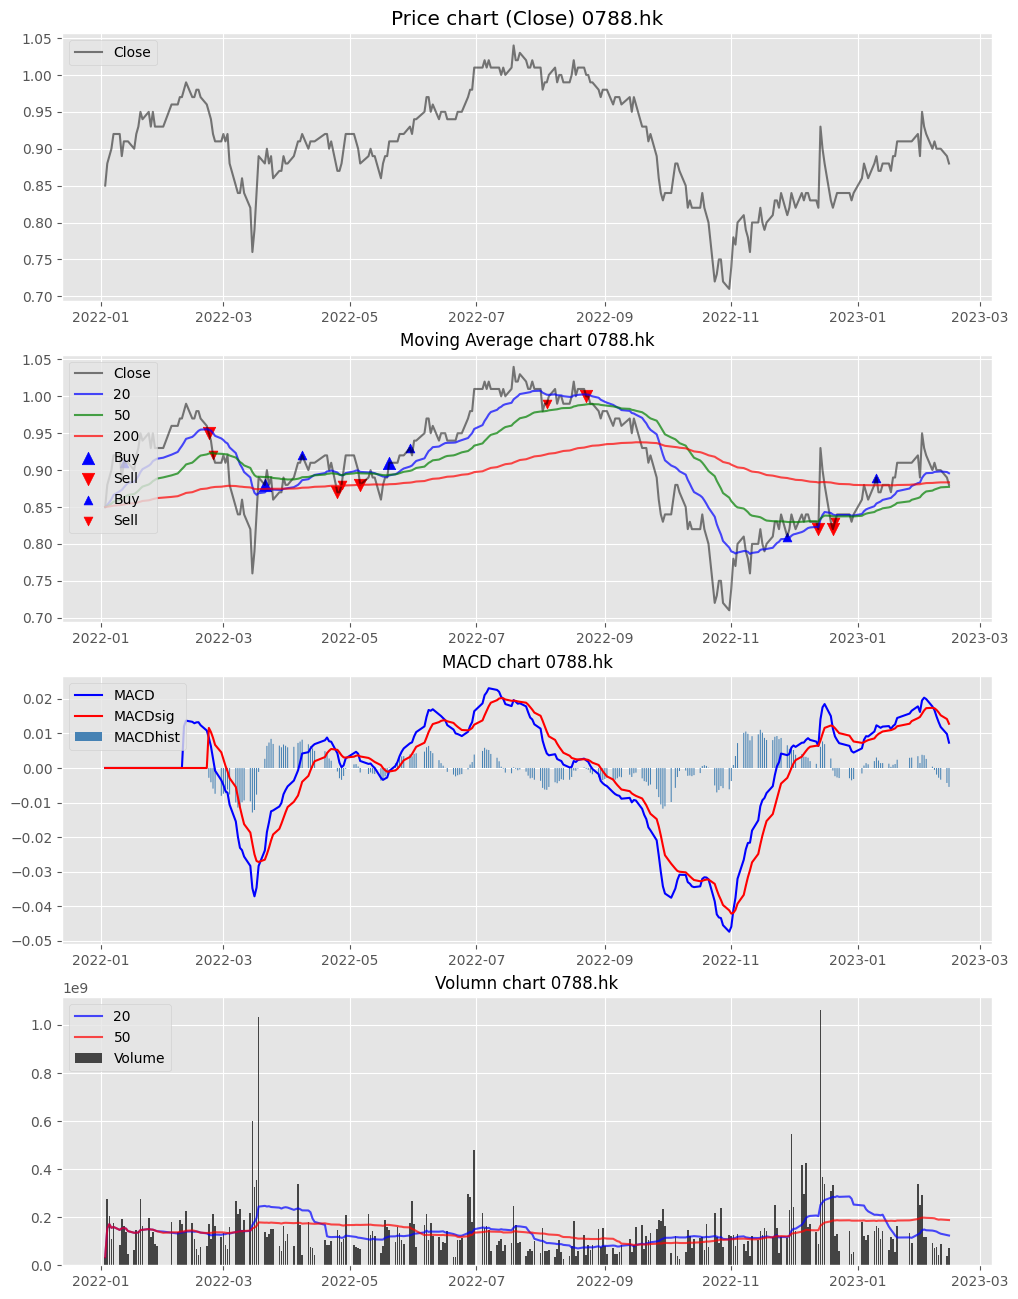

===== Plot signal chart for  0371.hk  =====
Trading Date:  	 2023-02-14

Close Price:  	 1.99 		 ['-', '-', '-']
EMA_short 20 : 	 2.027 		 ['+', '-']
EMA_long 50 : 	 2.01 		 ['-']
EMA_x 200 : 	 2.166 		

MACD momentum is -0.0044 negative and moderate. (-0.2 ~ 0)
MACD is in 65.46 percentile

Number of above 20 EMA days in the past 5 days is 2.
Number of above 20 EMA days in the past 10 days is 2.
Number of above 50 EMA days in the past 5 days is 3.
Number of above 50 EMA days in the past 10 days is 6.


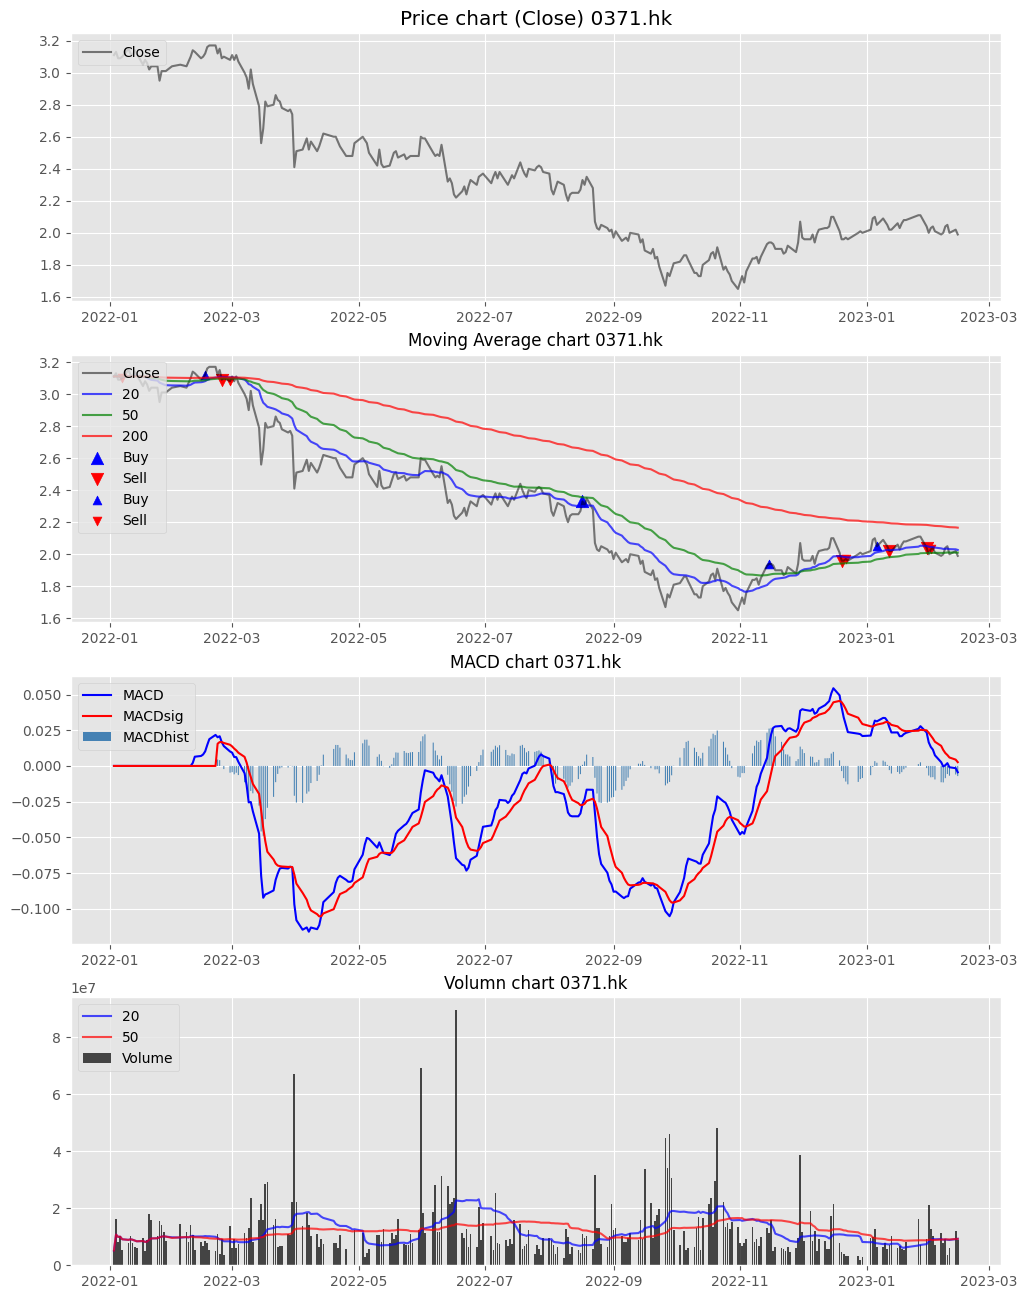

===== Plot signal chart for  1093.hk  =====
Trading Date:  	 2023-02-14

Bullish assessment: medium term is bullish

Close Price:  	 8.88 		 ['-', '-', '+']
EMA_short 20 : 	 8.949 		 ['+', '+']
EMA_long 50 : 	 8.896 		 ['+']
EMA_x 200 : 	 8.588 		

MACD momentum is -0.0059 negative and moderate. (-0.2 ~ 0)
MACD is in 55.02 percentile

Number of above 20 EMA days in the past 5 days is 0.
Number of above 20 EMA days in the past 10 days is 2.
Number of above 50 EMA days in the past 5 days is 2.
Number of above 50 EMA days in the past 10 days is 5.


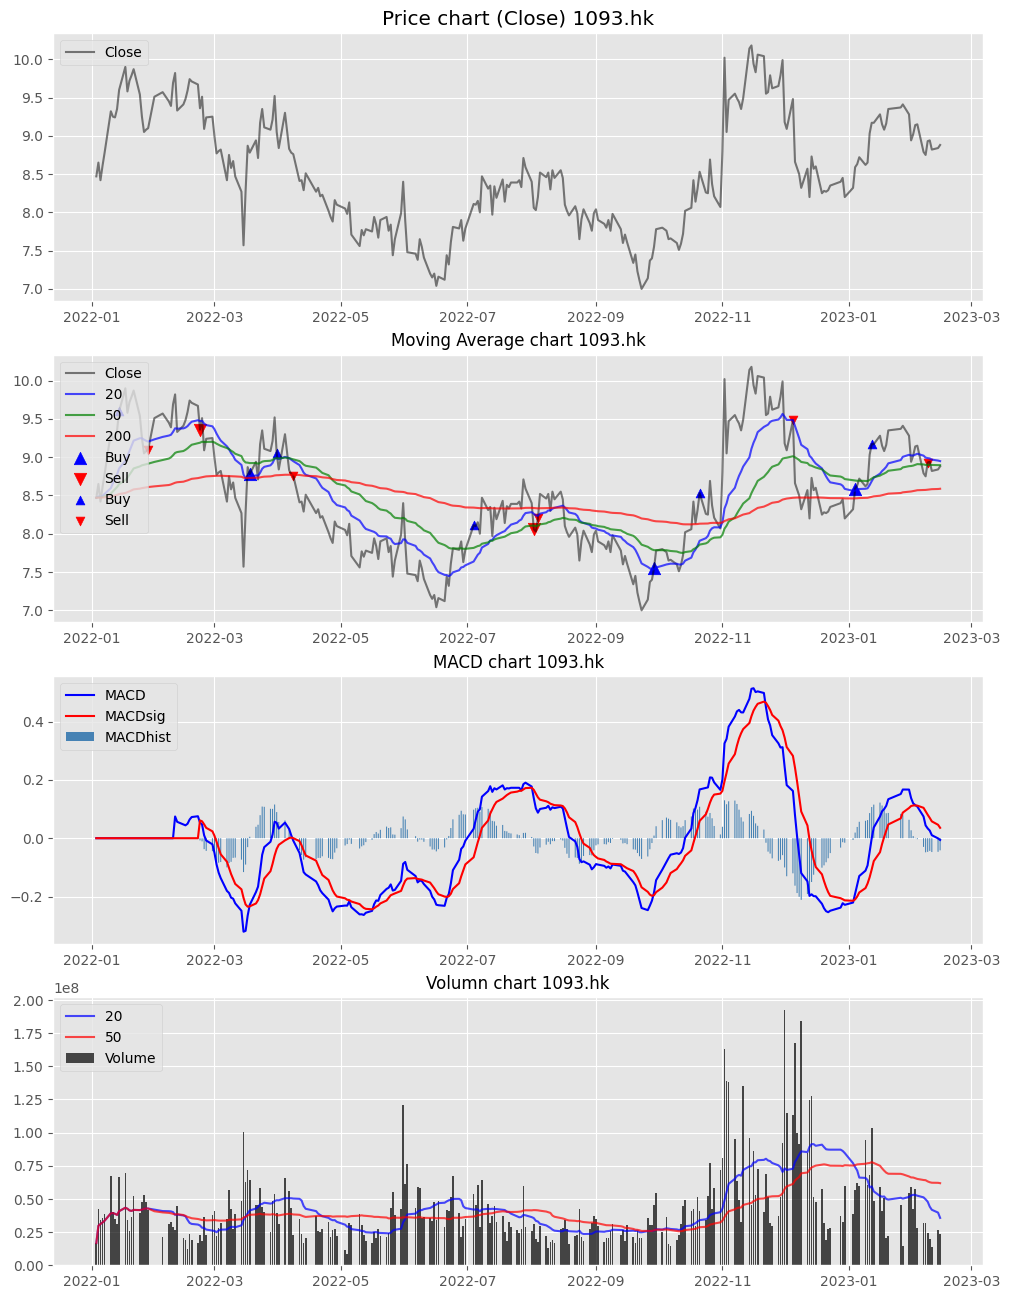

===== Plot signal chart for  6837.hk  =====
Trading Date:  	 2023-02-14

Bullish assessment: short term is bullish

Close Price:  	 5.3 		 ['-', '+', '+']
EMA_short 20 : 	 5.331 		 ['+', '+']
EMA_long 50 : 	 5.12 		 ['-']
EMA_x 200 : 	 5.177 		

MACD momentum is 0.0678 positive and moderate. (0 ~ 0.2)
MACD is in 77.51 percentile

Number of above 20 EMA days in the past 5 days is 2.
Number of above 20 EMA days in the past 10 days is 5.
Number of above 50 EMA days in the past 5 days is 5.
Number of above 50 EMA days in the past 10 days is 10.


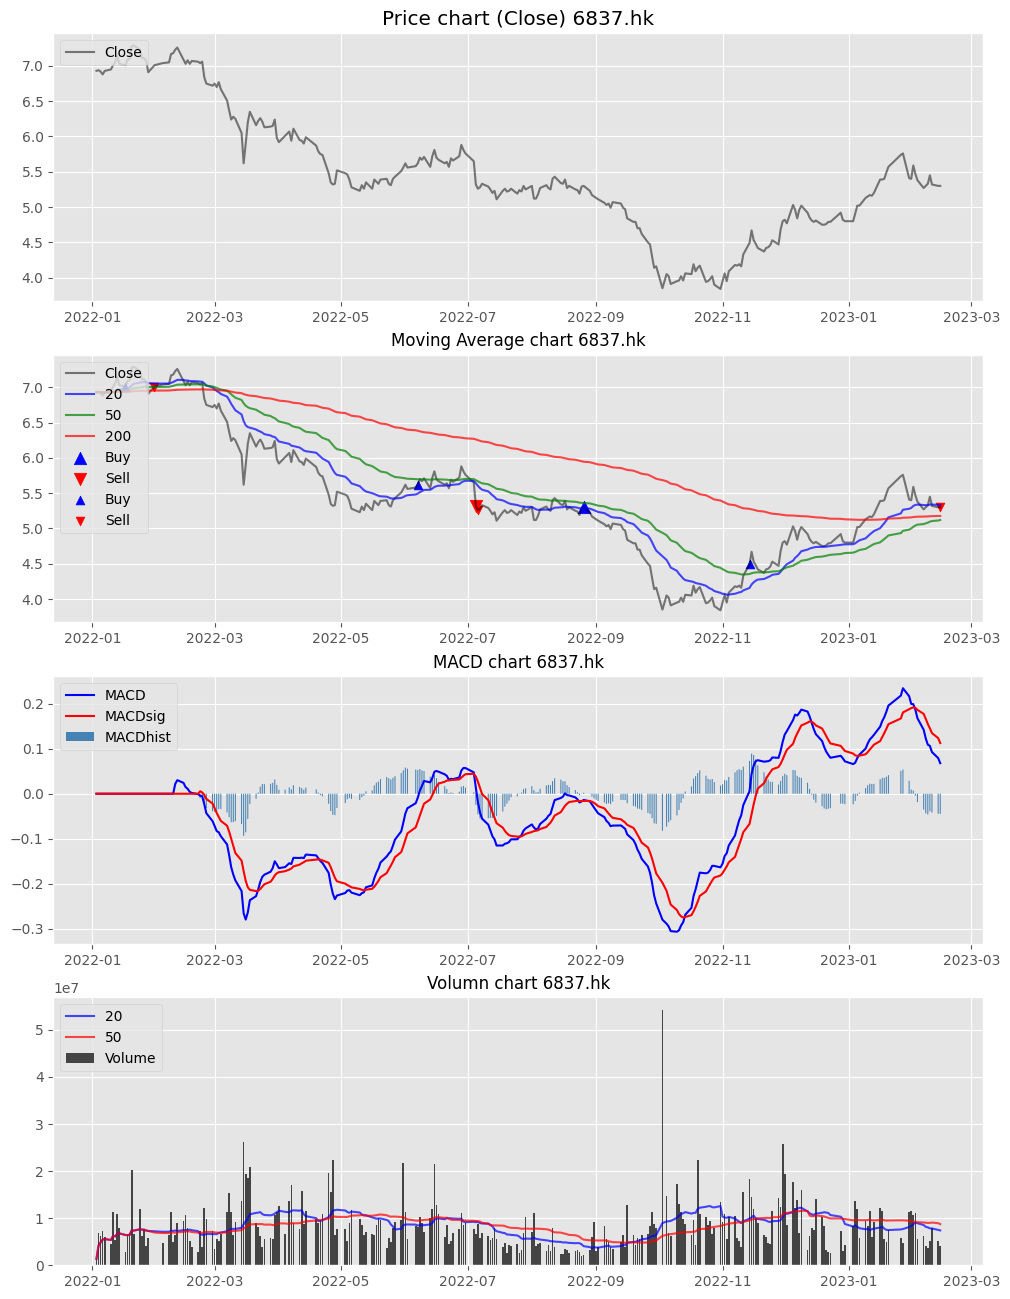

===== Plot signal chart for  0357.hk  =====
Trading Date:  	 2023-02-14

Bullish assessment: medium term is bullish

Close Price:  	 21.5 		 ['-', '-', '+']
EMA_short 20 : 	 22.496 		 ['+', '+']
EMA_long 50 : 	 22.039 		 ['+']
EMA_x 200 : 	 20.214 		

MACD momentum is -0.3047 negative and moderate. (-0.2 ~ 0)
MACD is in 36.95 percentile

Number of above 20 EMA days in the past 5 days is 0.
Number of above 20 EMA days in the past 10 days is 0.
Number of above 50 EMA days in the past 5 days is 2.
Number of above 50 EMA days in the past 10 days is 4.


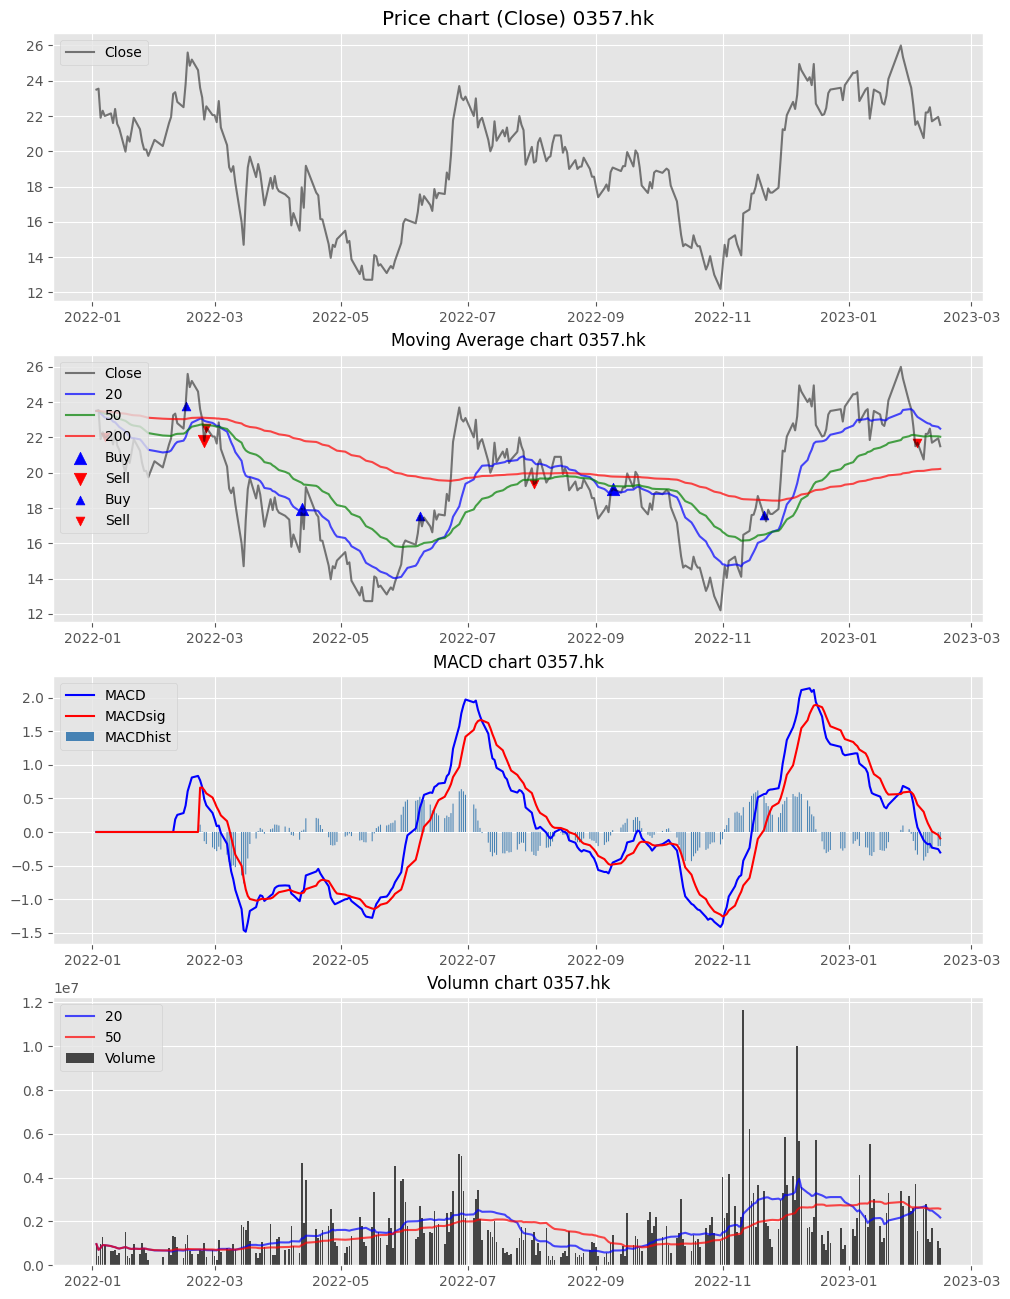

'\nshort term bullish: \n    1) 多头排列比空头排列多。\n    2) 最近5个交易日中，至少有3天闭市价在20日均线以上。\n    \nshort term bearish: \n    1) 空头排列比多头排列多。\n    2) 最近5个交易日中，至少有3天闭市价在20日均线以下。\n'

ticker      bullish_score    bearish_score     MACD    MACD_pctl_score    bullish_days_p5  short_term_trend    trading_date
--------  ---------------  ---------------  -------  -----------------  -----------------  ------------------  --------------
0788.hk                 3                3   0.0073              61.85                  3  bullish             2023-02-14
0371.hk                 1                5  -0.0044              65.46                  2  bearish             2023-02-14
1093.hk                 4                2  -0.0059              55.02                  0  bearish             2023-02-14
6837.hk                 4                2   0.0678              77.51                  2  bearish             2023-02-14
0357.hk                 4                2  -0.3047              36.95                  0  bearish             2023-02-14


In [26]:
# tt
# Holdings
tickers1 = ['0788.hk','0371.hk','1093.hk','6837.hk','0357.hk']
# ETF
tickers2 = ['2828.hk','2822.hk','3032.hk']

# Tech
tickers3 = ['6060.hk','1951.hk','1833.hk','0241.hk','0354.hk']
# Others
tickers4 = ['0981.hk','2202.hk','0020.hk','9888.hk','6862.hk']
# Telcom.
tickers5 = ['0941.hk','0762.hk','0728.hk','0788.hk']

# Bottom pattern.
tickers6 = ['6060.hk','6862.hk','0354.hk']

# ttt
tickers = tickers1 + tickers2 + tickers3 + tickers4 + tickers5
tickers = tickers1


#start_date = '2020-01-01'
start_date = '2022-01-01'

#end_date = '2022-01-01'
end_date = ''

EMA_short = 20
EMA_long = 50
EMA_x = 200

Volume_short = 20
Volume_long = 50

# Plot daily MV and MACD chart.
tickers_assess_sum = plot_signals_for_tickers_daily(tickers, start_date,end_date)

# Display tickers short term assessment summary.
'''
short term bullish: 
    1) 多头排列比空头排列多。
    2) 最近5个交易日中，至少有3天闭市价在20日均线以上。
    
short term bearish: 
    1) 空头排列比多头排列多。
    2) 最近5个交易日中，至少有3天闭市价在20日均线以下。
'''

display_tickers_sum(tickers_assess_sum)



In [27]:
# # Plot hourly MV and MACD chart.
# tickers = ['0788.hk']
# start_date = '2023-02-01'
# tickers_assess_sum = plot_signals_for_tickers_hourly(tickers, start_date,end_date)


In [28]:
# Display daily, weekly and monthly charts in yahoo finance.
yf_chart = 'N'
if yf_chart == 'Y':
    display_yf_chart(tickers)
    
